In [30]:
from HySpec_Image_Processing import HDR_Image
from get_pixel_mosaic import create_arrays
from M3_UnZip import M3_unzip
import os
import matplotlib.pyplot as plt
import numpy as np
from fancy_spec_plot import fancy_spec_plot
from fancy_spec_plot import plot_numpy_images
from spec_average import spec_avg
from scipy import interpolate as interp
from matplotlib.animation import FuncAnimation
from cubic_spline_image import cubic_spline_image
from cubic_spline_image import removeNAN
import spectral as sp
from copy import copy
import tifffile as tf

##### Getting necessary data arrays and M3 stamp list

In [3]:
if 'shadow' not in locals():
    shadow,imgStats,mosaicArray,mosaicStats = create_arrays(r'D:/Data')
    print ('Arrays Loaded')
elif 'shadow' in locals():
    print ('Arrays Exist')

hdrFileList,hdrFilesPath = M3_unzip(select=False,folder=r'D:/Data/20230209T095534013597')
stampList = []
for file in hdrFileList:
    stampList.append(HDR_Image(os.path.join(hdrFilesPath,file)))

.zip Files have already been extracted
Loading Images...


C:\Users\zacha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Images Loaded at 12.838490009307861 seconds
Getting list of shadow arrays...
2009-04-17_19-33-20_shadow.npy is already saved.
2009-05-15_04-30-23_shadow.npy is already saved.
2009-05-15_04-31-07_shadow.npy is already saved.
2009-06-05_16-32-32_shadow.npy is already saved.
2009-06-10_15-36-15_shadow.npy is already saved.
2009-06-12_10-07-53_shadow.npy is already saved.
2009-06-20_13-43-22_shadow.npy is already saved.
2009-06-24_02-43-43_shadow.npy is already saved.
2009-07-12_17-41-32_shadow.npy is already saved.
2009-07-17_04-12-42_shadow.npy is already saved.
2009-07-30_11-49-42_shadow.npy is already saved.
2009-08-12_19-51-13_shadow.npy is already saved.
2009-08-13_21-27-53_shadow.npy is already saved.
2009-08-14_06-00-13_shadow.npy is already saved.
List of shadows arrays filled at 13.079123258590698 seconds
Getting individual image statistics...
2009-04-17_19-33-20_statistics.csv is already saved.
2009-05-15_04-30-23_statistics.csv is already saved.
2009-05-15_04-31-07_statistics.c

C:\Users\zacha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


##### Getting average reflectance of South Pole (R<sub>bi</sub>)

In [4]:
def get_avg_rfl_data(stampList,plot_data=False):
    wvl = stampList[0].hdr.bands.centers[2:]
    rfl_avgSouthPole=np.zeros(83)
    rfl_stdSouthPole=np.zeros(83)
    for n in range(mosaicArray.shape[0]):
        rfl_avgSouthPole[n] = np.average(mosaicArray[n,:])
        rfl_stdSouthPole[n] = np.std(mosaicArray[n,:])

    
    # Plots Average Reflectance Data
    if plot_data == True:
        fig,ax = plt.subplots(1,1)
        fancy_spec_plot(fig,ax,wvl[21:73],rfl_avgSouthPole[21:73],std=rfl_stdSouthPole[21:73],
                        title="Average Reflectance of Non-Shaded Lunar South Pole",
                        ylabel= 'Reflectance', xlabel = 'Wavelength (\u03BCm)')
        
    return wvl,rfl_avgSouthPole,rfl_stdSouthPole

##### Makes shadow correction as in Li et al., 2018

Obtaining average south pole reflectance (R_bi)...
R_bi obtained
Obtaining original reflectance image (R_meas)...
R_meas Obtained
Running Li et al. Correction...


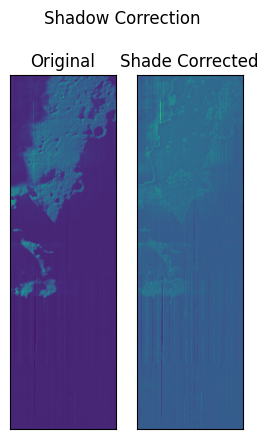

In [31]:
print ('Obtaining average south pole reflectance (R_bi)...')
wvl, rfl_avgSP, rfl_stdSP = get_avg_rfl_data(stampList, plot_data=False)
wvl = np.array(wvl)
allowedIndices = np.where((wvl>900)&(wvl<2600))[0]
allowedWvl = wvl[allowedIndices]
R_bi = rfl_avgSP[allowedIndices]
print ('R_bi obtained')

print ('Obtaining original reflectance image (R_meas)...')
hdr = sp.envi.open(r"D:/Data/20230209T095534013597/extracted_files/hdr_files/m3g20090417t193320_v01_rfl/m3g20090417t193320_v01_rfl.hdr")
R_c = hdr.read_bands(allowedIndices) # To fill in corrected values.
R_meas = hdr.read_bands(allowedIndices)
print ('R_meas Obtained')

print ('Running Li et al. Correction...')
xShade,yShade = np.where(shadow[0]==0)
xLight,yLight = np.where(shadow[0]!=0)
R_c[xShade,yShade,:] = R_c[xShade,yShade,:]/R_bi

plot_numpy_images(R_meas[:,:,0],R_c[:,:,0],titles=['Original','Shade Corrected'],
                  figtitle='Shadow Correction',figsize=(3,5),colorMap='binary')


In [27]:
tf.imwrite(r'D:/Data/Figures/Shade_Correction_Band0.png',R_c[:,:,0])



##### Applying cubic spline correction to spectrum values

In [6]:
spectrumImage_avg,spectrumImage_cspl = cubic_spline_image(R_c,allowedWvl,5)
#plt.imshow(spectrumImage_avg[:,:,2])

An array of size (1017, 304, 59) and band centers from 910.14μm to 2576.96μm had been loaded
(1017, 59) (1017, 59)
Averaging across x coordinate...


##### Plotting some pixel values

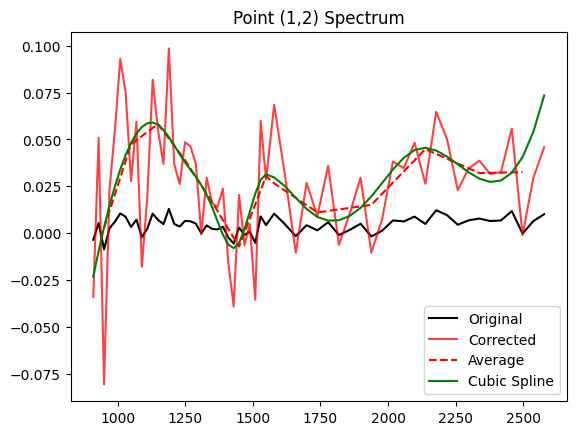

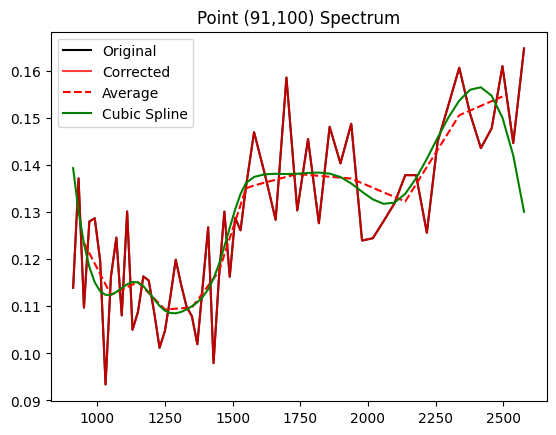

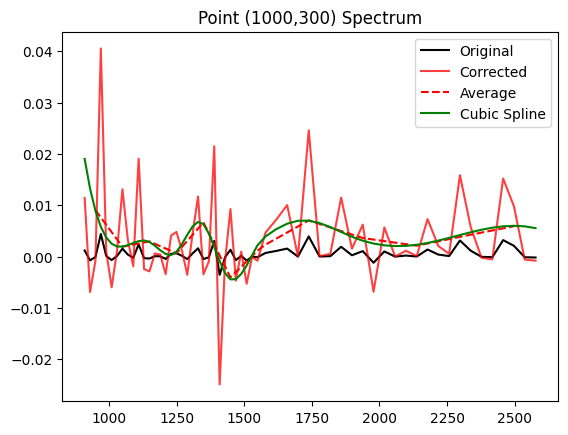

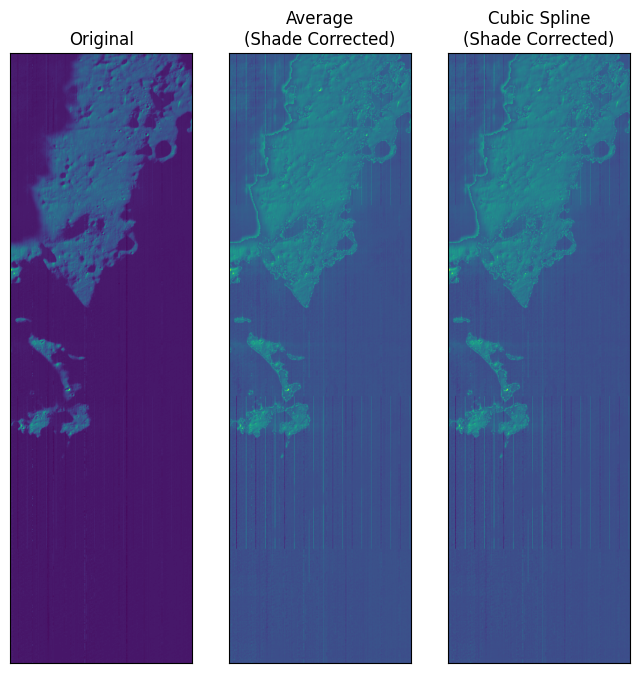

In [7]:
def plot_correction(x,y):
    fig,ax = plt.subplots(1,1)
    ax.plot(allowedWvl,R_meas[x,y,:],label='Original',color='k')
    ax.plot(allowedWvl,R_c[x,y,:],label='Corrected',color='red',alpha=0.75)
    ax.plot(allowedWvl,spectrumImage_avg[x,y,:],label='Average',color='red',ls='--')
    ax.plot(allowedWvl,spectrumImage_cspl[x,y,:],label='Cubic Spline',color='Green')
    ax.set_title(f'Point ({x},{y}) Spectrum')
    ax.legend()
plot_correction(1,2)
plot_correction(91,100)
plot_correction(1000,300)

def plot_numpy_images(*args:np.ndarray,**kwargs:np.ndarray):
    defaultKwargs = {"titles":[],"figsize":(8,16)}
    kwargs = {**defaultKwargs,**kwargs}

    fig = plt.figure(figsize=kwargs.get("figsize"))
    col_num = len(args)
    for num,image in enumerate(args):
        ax = fig.add_subplot(1,col_num,num+1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(kwargs.get('titles')[num])
        ax.imshow(image)
    

plot_numpy_images(R_meas[:,:,32],spectrumImage_avg[:,:,32],spectrumImage_cspl[:,:,32],
                  titles=['Original','Average\n(Shade Corrected)','Cubic Spline\n(Shade Corrected)'])

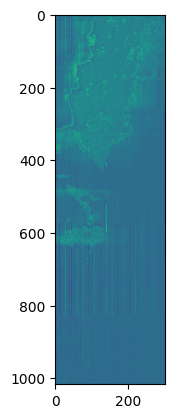

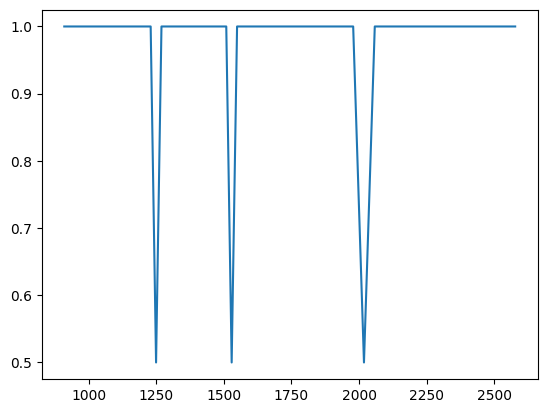

In [8]:
def get_minima(wvlValues:'np.ndarray',img:'np.ndarray',x:'int', y:'int',**kwargs) -> 'tuple':
    defaultKwargs = {"plotMins":False}
    kwargs = {**defaultKwargs,**kwargs}

    rflValues = img[x,y,:]

    diff_list = []
    wvlMinima = ()
    for n in range(0, len(rflValues)):
        if n < len(rflValues)-1:
            diff = rflValues[n]-rflValues[n+1]
            diff_list.append(diff)
            if n > 2 and diff < 0 and diff_list[-2] > 0:
                wvlMinima += (wvlValues[n],)
    
    ##Check if minima reflect water spectrum
    validWvl = np.array(([1.130,1.350],[1.420,1.740],[1.820,2.200]))
    waterBands = ()
    for val in wvlMinima:
        if any(val/1000 > i and val/1000 < j for i,j in zip(validWvl[:,0],validWvl[:,1])):
            waterBands += (val,)
        else:
            pass
    
    if kwargs.get('plotMins') == True:
        fig,ax = plt.subplots(1,1)
        ax.plot(wvlValues,rflValues,label='Cubic Spline Fit')
        for val in wvlMinima:
            ax.vlines(val,rflValues.min(),rflValues.max())

    if len(wvlMinima) == 3 and len(waterBands) == 3:
        return waterBands,True
    else:
        return wvlMinima,False
        #print (f'Point ({x},{y}) does not contain water ice.')

#get_minima(allowedWvl,spectrumImage_cspl,91,100)

def analyze_image(image):
    waterPixels = np.zeros([1,5]).astype(int)
    xCoords,yCoords = range(int(image.shape[0])),range(int(image.shape[1]))
    xMesh,yMesh = np.meshgrid(xCoords,yCoords)

    num = 0
    for x,y in zip(xMesh.flatten(),yMesh.flatten()):
        if num < 1000000:
            print (f'\r{num+1}/{len(xMesh.flatten())} Points Processed ({num/len(xMesh.flatten()):.0%})',end='\r')
            waterBands,add = get_minima(allowedWvl,image,x,y)
            if add == True:
                waterPixels = np.concatenate([waterPixels,np.array([(x,y,*waterBands)])])
            elif add == False:
                pass
            num+=1
        else:
            print (f'\nLoop broken at {num}')
            break
    
    #waterPixels = np.delete(waterPixels,0)
    return waterPixels

#analyzeImage()

testImage = copy(spectrumImage_cspl)
testSpectrum = np.ones(59)
validWvl = np.array(([1.130,1.350],[1.420,1.740],[1.820,2.200]))
validIndices = np.zeros(1).astype(int)
for mi,mx in zip(validWvl[:,0],validWvl[:,1]):
    wBand = np.where((allowedWvl/1000>mi)&(allowedWvl/1000<mx))
    validIndices = np.concatenate([validIndices,np.array([int(np.median(wBand[0]))])])
    #print (allowedWvl[wBand]/1000)

#print (validIndices)
validIndices = np.delete(validIndices,0)
testSpectrum[validIndices] = 0.5

plt.imshow(spectrumImage_cspl[:,:,2])
fig = plt.figure()
plt.plot(allowedWvl,testSpectrum)
#plt.plot(xtest,f(xtest))

testImage[0,0,:]=testSpectrum

waterPixels = analyze_image(spectrumImage_cspl)

#get_minima(allowedWvl,testImage,211,0,plotMins=True)

In [9]:
myarr = np.zeros([1,5]).astype(int)
mytup = (1,2,3)
myarr = np.concatenate([myarr,np.array([(9,9,*mytup)])])

myarr


array([[0, 0, 0, 0, 0],
       [9, 9, 1, 2, 3]])

,,Band 1,Band 2,Band 3
x,y,,,
211.0,0.0,1229.53,1548.92,2057.95
257.0,0.0,1329.34,1738.56,2177.72
355.0,0.0,1149.68,1508.99,1898.25
390.0,0.0,1229.53,1658.71,2137.80
392.0,0.0,1149.68,1349.30,2097.87
...,...,...,...,...
977.0,303.0,1329.34,1578.86,1978.10
981.0,303.0,1329.34,1738.56,2097.87
986.0,303.0,1309.38,1548.92,1978.10


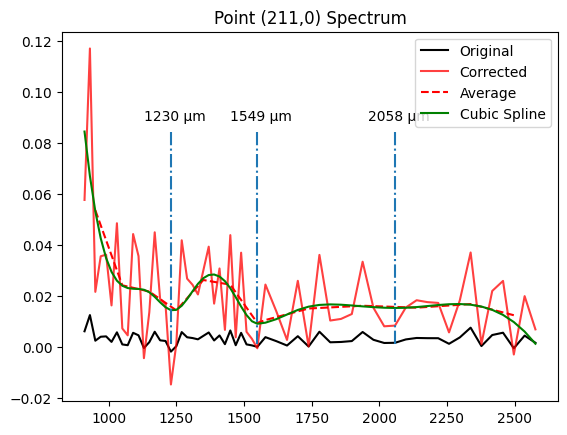

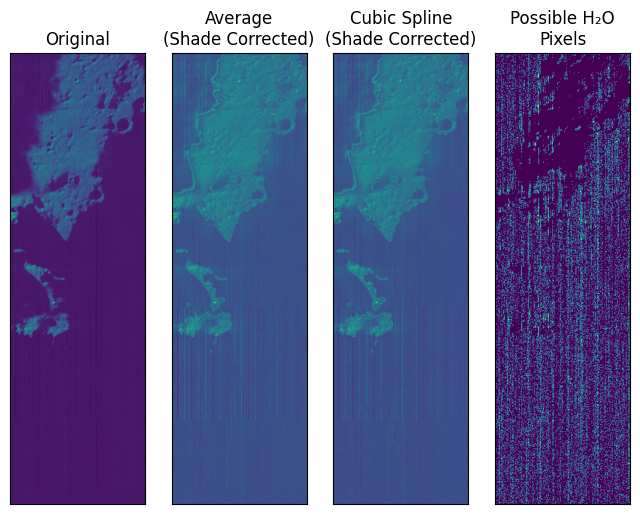

In [12]:
import pandas as pd
#print (waterPixels)
waterDf = pd.DataFrame(waterPixels)
waterDf.columns = ['x','y','Band 1','Band 2','Band 3']
waterDf.drop(waterDf.index[0],inplace=True)
waterDf.set_index(['x','y'],inplace=True)
display (waterDf)


def plot_correction_minima(x,y):
    fig,ax = plt.subplots(1,1)
    ax.plot(allowedWvl,R_meas[x,y,:],label='Original',color='k')
    ax.plot(allowedWvl,R_c[x,y,:],label='Corrected',color='red',alpha=0.75)
    ax.plot(allowedWvl,spectrumImage_avg[x,y,:],label='Average',color='red',ls='--')
    ax.plot(allowedWvl,spectrumImage_cspl[x,y,:],label='Cubic Spline',color='Green')
    if (x,y) in waterDf.index:
        wvlMin = waterDf.loc[(x,y)]
        for val in wvlMin:
            ax.vlines(val,spectrumImage_cspl[x,y,:].min(),spectrumImage_cspl[x,y,:].max(),ls='-.')
            ax.text(val-100,spectrumImage_cspl[x,y,:].max()+0.05*spectrumImage_cspl[x,y,:].max(),f'{val:.0f} \u03BCm')
    ax.set_title(f'Point ({x},{y}) Spectrum')
    ax.legend()


plot_correction_minima(211,0)
water_where = np.zeros(R_meas.shape)
for x,y in waterDf.index:
    water_where[int(x),int(y),:] = np.ones((len(allowedWvl)))

plot_numpy_images(R_meas[:,:,32],spectrumImage_avg[:,:,32],spectrumImage_cspl[:,:,32],water_where[:,:,32],
                  titles=['Original','Average\n(Shade Corrected)','Cubic Spline\n(Shade Corrected)','Possible H\u2082O\nPixels'])

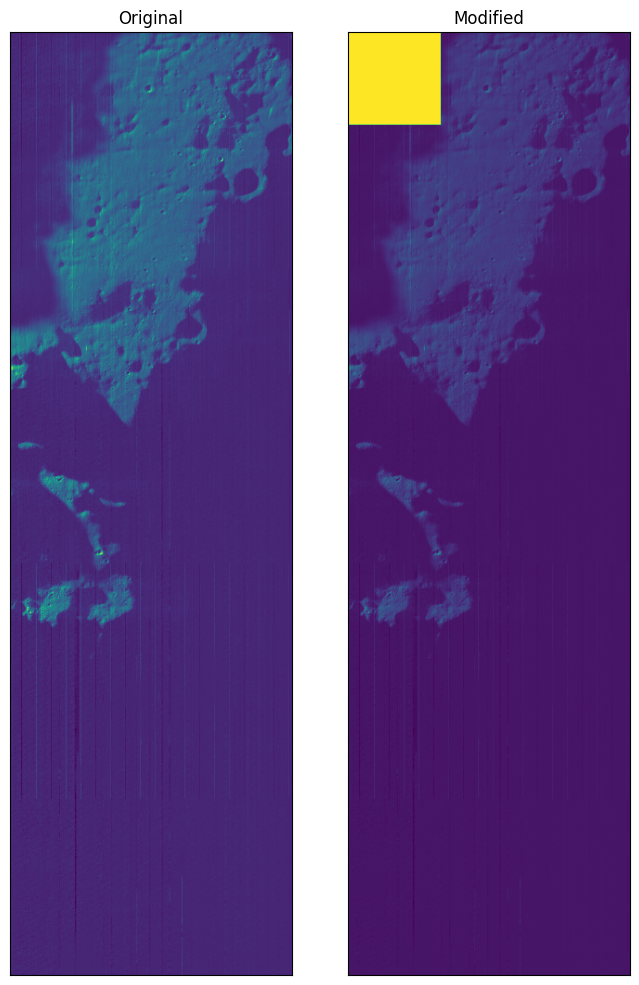

In [11]:


myarr = np.ones((len(allowedWvl)))

test = copy(R_meas)

test[0:100,0:100,:] = myarr

plot_numpy_images(R_meas[:,:,0],test[:,:,0],titles=['Original','Modified'])